In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install fastparquet
!python3 -m pip install  python-snappy
!sudo apt-get install libsnappy-dev
!pip install tensorflow-addons
!python3 -m pip install pyarrow
! pip install hyperas
!pip install --upgrade numpy

     |████████████████████████████████| 1.2 MB 2.8 MB/s 
     |████████████████████████████████| 125 kB 94.9 MB/s 
     |████████████████████████████████| 59 kB 8.9 MB/s 
     |████████████████████████████████| 1.5 MB 72.2 MB/s 
  Created wheel for thrift: filename=thrift-0.15.0-cp37-cp37m-linux_x86_64.whl size=348201 sha256=be26e65f66c9c36c46ef43bcafe07a2ebbfc3b21c146f37c62c0527c78ebbdd4
  Stored in directory: /root/.cache/pip/wheels/ba/1f/8e/e6fd36837eecf3d1f2b23f1729477e8e06558d8d60b7093f51
Successfully built thrift
     |████████████████████████████████| 55 kB 1.8 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libsnappy-dev
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 27.2 kB of archives.
After this operation, 108 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libsnappy-dev amd64 1.1.7-1 [27.2 kB]
F

# Import the data 

In [3]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import fastparquet as fp
import matplotlib.pyplot as plt

from time import time
from collections import Counter
from scipy.integrate import trapz
from sklearn.metrics import confusion_matrix, precision_score

# Deep Learning libraries
import tensorflow as tf
from tensorflow_addons.optimizers import RectifiedAdam, Lookahead
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Custom libraries
os.chdir('/content/gdrive/My Drive/phyto_curves_reco')
from losses import CB_loss, categorical_focal_loss
from from_cytoclus_to_curves_values import extract_labeled_curves, extract_non_labeled_curves
from dataset_preprocessing import homogeneous_cluster_names_swings, gen_train_test_valid
from viz_functions import plot_2Dcyto

current_dir = '/content/gdrive/My Drive/data/SWINGS/L2/Pulse/'

          
os.chdir('/content/gdrive/My Drive/data/SWINGS')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
train = np.load(current_dir + 'train.npz', allow_pickle = True)
valid = np.load(current_dir + 'valid.npz', allow_pickle = True)

X_train = train['X']
X_valid = valid['X']

y_train = train['y']
y_valid = valid['y']

# Free the memory 
del(train)
del(valid)

In [ ]:
X_train.mean((0 , 1), keepdims = True).shape

(1, 1, 5)

In [ ]:
X_train = X_train / X_train.mean((0 , 1), keepdims = True)
X_valid = X_valid / X_valid.mean((0 , 1), keepdims = True)

In [ ]:
# Import the nomenclature created by the "gen_train_test_valid" function
tn = pd.read_csv(current_dir + '/train_test_nomenclature.csv')
tn.columns = ['name', 'id']

# Benchmark model

In [5]:
# Load the model 
from keras.models import load_model
bench_model = load_model('/content/gdrive/My Drive/Models/SWINGS/cnn_hyperopt_model_categ2')

OSError: ignored

In [ ]:
X_valid.shape

(365863, 120, 5)

In [ ]:
for ix, layer in enumerate(bench_model.layers):
    if hasattr(bench_model.layers[ix], 'kernel_initializer') and \
            hasattr(bench_model.layers[ix], 'bias_initializer'):
        weight_initializer = bench_model.layers[ix].kernel_initializer
        bias_initializer = bench_model.layers[ix].bias_initializer

        old_weights, old_biases = bench_model.layers[ix].get_weights()

        bench_model.layers[ix].set_weights([
            weight_initializer(shape=old_weights.shape),
            bias_initializer(shape=len(old_biases))])

In [ ]:
sb_weights = '/content/gdrive/My Drive/Models/SWINGS/small_bench_weights2.hdf5'

In [ ]:
N_CLASSES = y_train.shape[1]
max_len = X_train.shape[1]
nb_curves = X_train.shape[2]

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
check = ModelCheckpoint(filepath = sb_weights,\
                        verbose = 1, save_best_only=True)

# Defining the weights: Take the average over SSLAMM data
weights = 0.3
w = 1 / (np.sum(y_valid, axis = 0)) ** weights
w = w / w.sum()
w = dict(zip(range(N_CLASSES),w))

batch_size = 64*4
STEP_SIZE_TRAIN = (len(X_train) // batch_size) + 1
STEP_SIZE_VALID = (len(X_valid) // (128 * 8)) + 1

In [ ]:
result_sb = bench_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), \
                steps_per_epoch = STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID,\
                epochs = 120, class_weight = w, shuffle=True, verbose=2, callbacks = [check, es])

bench_model.load_weights(sb_weights)

Epoch 1/120
178/178 - 6s - loss: 0.4517 - accuracy: 0.2322 - val_loss: 2.1456 - val_accuracy: 0.0311

Epoch 00001: val_loss improved from inf to 2.14563, saving model to /content/gdrive/My Drive/Models/SWINGS/small_bench_weights2.hdf5
Epoch 2/120
178/178 - 2s - loss: 0.1490 - accuracy: 0.4325 - val_loss: 2.1304 - val_accuracy: 0.0503

Epoch 00002: val_loss improved from 2.14563 to 2.13043, saving model to /content/gdrive/My Drive/Models/SWINGS/small_bench_weights2.hdf5
Epoch 3/120
178/178 - 2s - loss: 0.0993 - accuracy: 0.5227 - val_loss: 1.6234 - val_accuracy: 0.1946

Epoch 00003: val_loss improved from 2.13043 to 1.62341, saving model to /content/gdrive/My Drive/Models/SWINGS/small_bench_weights2.hdf5
Epoch 4/120
178/178 - 3s - loss: 0.0748 - accuracy: 0.6974 - val_loss: 0.9443 - val_accuracy: 0.8605

Epoch 00004: val_loss improved from 1.62341 to 0.94425, saving model to /content/gdrive/My Drive/Models/SWINGS/small_bench_weights2.hdf5
Epoch 5/120
178/178 - 2s - loss: 0.0520 - accura

# Benchmark big

In [ ]:
bb_weights = '/content/gdrive/My Drive/Models/SWINGS/big_bench_weights.hdf5'

In [ ]:
N_CLASSES = y_train.shape[1]
max_len = X_train.shape[1]
nb_curves = X_train.shape[2]

dp = 0.3358541

sequence_input = tf.keras.layers.Input(shape=(max_len, nb_curves), dtype='float32')

filter_size = 3
x = tf.keras.layers.Conv1D(32, filter_size, activation='relu')(sequence_input)
x = tf.keras.layers.Conv1D(64, filter_size, activation='relu')(x)
x = tf.keras.layers.Conv1D(128, filter_size, activation='relu')(x)

# Average the created features maps
average = tf.keras.layers.GlobalAveragePooling1D()(x)
dense2 = tf.keras.layers.Dense(64, activation='relu')(average) 
drop2 = tf.keras.layers.Dropout(dp)(dense2)
dense3 = tf.keras.layers.Dense(32, activation='relu')(drop2)
drop3 = tf.keras.layers.Dropout(dp)(dense3)
dense4 = tf.keras.layers.Dense(16, activation='relu')(drop3)
drop4 = tf.keras.layers.Dropout(dp)(dense4)

predictions = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(dense2)
bench_big = tf.keras.Model(sequence_input, predictions)

#==================================================
# Specifying the optimizer
#==================================================
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
check = ModelCheckpoint(filepath=bb_weights,\
                        verbose = 1, save_best_only=True)

optim_ch = 'ranger'
lr = 0.007629758 #modif

if optim_ch == 'adam':
    optim = tf.keras.optimizers.Adam(learning_rate = lr)
    sync_period = None
    slow_step_size = None
else:
    sync_period = 3
    slow_step_size = 0.41782
    rad = RectifiedAdam(learning_rate = lr)
    optim = Lookahead(rad, sync_period = sync_period, slow_step_size = slow_step_size)


# Defining the weights: Take the average over SSLAMM data
'''
weights = 0.3
w = 1 / (np.sum(y_valid, axis = 0))**weights
w = w / w.sum()
w = dict(zip(range(N_CLASSES),w))
'''
w = dict(zip(tn['id'], np.full(N_CLASSES, 1 / N_CLASSES)))


batch_size = 64*4
STEP_SIZE_TRAIN = (len(X_train) // batch_size) + 1
STEP_SIZE_VALID = (len(X_valid) // (128 * 8)) + 1

bench_big.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optim)

In [ ]:
result_bb = bench_big.fit(X_train, y_train, validation_data=(X_valid, y_valid), \
                steps_per_epoch = STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID,\
                epochs = 120, class_weight = w, shuffle=True, verbose=2, callbacks = [check, es])

bench_big.load_weights(bb_weights)

Epoch 1/120
178/178 - 6s - loss: 0.7227 - accuracy: 0.6018 - val_loss: 0.8291 - val_accuracy: 0.8662

Epoch 00001: val_loss improved from inf to 0.82911, saving model to /content/gdrive/My Drive/Models/SWINGS/big_bench_weights.hdf5
Epoch 2/120
178/178 - 3s - loss: 0.0710 - accuracy: 0.8775 - val_loss: 0.3678 - val_accuracy: 0.9203

Epoch 00002: val_loss improved from 0.82911 to 0.36776, saving model to /content/gdrive/My Drive/Models/SWINGS/big_bench_weights.hdf5
Epoch 3/120
178/178 - 3s - loss: 0.0499 - accuracy: 0.9115 - val_loss: 0.2337 - val_accuracy: 0.9573

Epoch 00003: val_loss improved from 0.36776 to 0.23366, saving model to /content/gdrive/My Drive/Models/SWINGS/big_bench_weights.hdf5
Epoch 4/120
178/178 - 3s - loss: 0.0355 - accuracy: 0.9326 - val_loss: 0.1624 - val_accuracy: 0.9587

Epoch 00004: val_loss improved from 0.23366 to 0.16237, saving model to /content/gdrive/My Drive/Models/SWINGS/big_bench_weights.hdf5
Epoch 5/120
178/178 - 3s - loss: 0.0292 - accuracy: 0.9378 -

# VGG small

In [ ]:
vggSmall_weights = '/content/gdrive/My Drive/Models/SWINGS/VGG_small2_weights.hdf5'

In [ ]:
N_CLASSES = y_train.shape[1]
max_len = X_train.shape[1]
nb_curves = X_train.shape[2]

dp = 0.3358541

sequence_input = tf.keras.layers.Input(shape=(max_len, nb_curves), dtype='float32')

# A 1D convolution with 128 output channels: Extract features from the curves
kernel_size = 3 # Earlier on: 3, 5, 7
x = tf.keras.layers.Conv1D(filters = 32, kernel_size = kernel_size, activation='relu')(sequence_input)
x = tf.keras.layers.AveragePooling1D(pool_size=2, strides=None, padding="valid", data_format="channels_last")(x)
x = tf.keras.layers.Conv1D(filters = 64, kernel_size = kernel_size, activation='relu')(x)
x = tf.keras.layers.AveragePooling1D(pool_size=2, strides=None, padding="valid", data_format="channels_last")(x)
x = tf.keras.layers.Conv1D(filters = 128, kernel_size = kernel_size, activation='relu')(x)

# Average the created features maps
average = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last')(x)
dense2 = tf.keras.layers.Dense(216, activation='relu')(average) 
drop2 = tf.keras.layers.Dropout(dp)(dense2)

predictions = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(drop2)
VGG_small = tf.keras.Model(sequence_input, predictions)

#==================================================
# Specifying the optimizer
#==================================================

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
check = ModelCheckpoint(filepath = vggSmall_weights,\
                        verbose = 1, save_best_only=True)


optim_ch = 'ranger'
lr = 0.007629758 #modif

if optim_ch == 'adam':
    optim = tf.keras.optimizers.Adam(learning_rate = lr)
    sync_period = None
    slow_step_size = None
else:
    sync_period = 3
    slow_step_size = 0.41782
    rad = RectifiedAdam(learning_rate = lr)
    optim = Lookahead(rad, sync_period = sync_period, slow_step_size = slow_step_size)


# Defining the weights: Take the average over SSLAMM data
weights = 0.3
w = 1 / (np.sum(y_valid, axis = 0))**weights
w = w / w.sum()
w = dict(zip(range(N_CLASSES),w))

batch_size = 64*4
STEP_SIZE_TRAIN = (len(X_train) // batch_size) + 1
STEP_SIZE_VALID = (len(X_valid) // (128 * 8)) + 1

VGG_small.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optim)

In [ ]:
result_VGGsmall = VGG_small.fit(X_train, y_train, validation_data=(X_valid, y_valid), \
                steps_per_epoch = STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID,\
                epochs = 120, class_weight = w, shuffle=True, verbose=2, callbacks = [check, es])

VGG_small.load_weights(vggSmall_weights)

Epoch 1/120
178/178 - 5s - loss: 0.4737 - accuracy: 0.5309 - val_loss: 1.3859 - val_accuracy: 0.7519

Epoch 00001: val_loss improved from inf to 1.38588, saving model to /content/gdrive/My Drive/Models/SWINGS/VGG_small2_weights.hdf5
Epoch 2/120
178/178 - 2s - loss: 0.0617 - accuracy: 0.8582 - val_loss: 0.3822 - val_accuracy: 0.9278

Epoch 00002: val_loss improved from 1.38588 to 0.38220, saving model to /content/gdrive/My Drive/Models/SWINGS/VGG_small2_weights.hdf5
Epoch 3/120
178/178 - 2s - loss: 0.0384 - accuracy: 0.9041 - val_loss: 0.2458 - val_accuracy: 0.9419

Epoch 00003: val_loss improved from 0.38220 to 0.24575, saving model to /content/gdrive/My Drive/Models/SWINGS/VGG_small2_weights.hdf5
Epoch 4/120
178/178 - 2s - loss: 0.0289 - accuracy: 0.9231 - val_loss: 0.2329 - val_accuracy: 0.9307

Epoch 00004: val_loss improved from 0.24575 to 0.23286, saving model to /content/gdrive/My Drive/Models/SWINGS/VGG_small2_weights.hdf5
Epoch 5/120
178/178 - 2s - loss: 0.0244 - accuracy: 0.93

# VGG big

In [ ]:
vggBig_weights = '/content/gdrive/My Drive/Models/SWINGS/VGG_big_weights.hdf5'

In [ ]:
N_CLASSES = y_train.shape[1]
max_len = X_train.shape[1]
nb_curves = X_train.shape[2]

dp = 0.3358541

sequence_input = tf.keras.layers.Input(shape=(max_len, nb_curves), dtype='float32')

# A 1D convolution with 128 output channels: Extract features from the curves
kernel_size = 3 # Earlier on: 3, 5, 7
x = tf.keras.layers.Conv1D(filters = 32, kernel_size = kernel_size, activation='relu')(sequence_input)
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv1D(filters = 32, kernel_size = kernel_size, activation='relu')(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling1D(pool_size=2, strides=None, padding="valid", data_format="channels_last")(x)
x = tf.keras.layers.Conv1D(filters = 64, kernel_size = kernel_size, activation='relu')(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv1D(filters = 64, kernel_size = kernel_size, activation='relu')(x)
x = tf.keras.layers.AveragePooling1D(pool_size=2, strides=None, padding="valid", data_format="channels_last")(x)
x = tf.keras.layers.Conv1D(filters = 128, kernel_size = kernel_size, activation='relu')(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv1D(filters = 128, kernel_size = kernel_size, activation='relu')(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv1D(filters = 128, kernel_size = kernel_size, activation='relu')(x)

# Average the created features maps
x = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x) 
x = tf.keras.layers.Dropout(dp)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x) 
x = tf.keras.layers.Dropout(dp)(x)

predictions = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(x)
VGG_big = tf.keras.Model(sequence_input, predictions)

#==================================================
# Specifying the optimizer
#==================================================

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
check = ModelCheckpoint(filepath=vggBig_weights,\
                        verbose = 1, save_best_only=True)


optim_ch = 'ranger'
lr = 0.007629758 #modif

if optim_ch == 'adam':
    optim = tf.keras.optimizers.Adam(learning_rate = lr)
    sync_period = None
    slow_step_size = None
else:
    sync_period = 3
    slow_step_size = 0.41782
    rad = RectifiedAdam(learning_rate = lr)
    optim = Lookahead(rad, sync_period = sync_period, slow_step_size = slow_step_size)


# Defining the weights: Take the average over SSLAMM data
'''
weights = 0.3
w = 1 / (np.sum(y_valid, axis = 0))**weights
w = w / w.sum()
w = dict(zip(range(N_CLASSES),w))
'''
w = dict(zip(tn['id'], np.full(N_CLASSES, 1 / N_CLASSES)))

batch_size = 64*4
STEP_SIZE_TRAIN = (len(X_train) // batch_size) + 1
STEP_SIZE_VALID = (len(X_valid) // (128 * 8)) + 1

VGG_big.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optim)

In [ ]:

result_VGGbig = VGG_big.fit(X_train, y_train, validation_data=(X_valid, y_valid), \
                steps_per_epoch = STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID,\
                epochs = 120, class_weight = w, shuffle=True, verbose=2, callbacks = [check, es])

VGG_big.load_weights(vggBig_weights)

Epoch 1/120
178/178 - 9s - loss: 0.2164 - accuracy: 0.4800 - val_loss: 0.6553 - val_accuracy: 0.8380

Epoch 00001: val_loss improved from inf to 0.65527, saving model to /content/gdrive/My Drive/Models/SWINGS/VGG_big_weights.hdf5
Epoch 2/120
178/178 - 4s - loss: 0.0963 - accuracy: 0.7821 - val_loss: 0.3671 - val_accuracy: 0.9234

Epoch 00002: val_loss improved from 0.65527 to 0.36706, saving model to /content/gdrive/My Drive/Models/SWINGS/VGG_big_weights.hdf5
Epoch 3/120
178/178 - 4s - loss: 0.0568 - accuracy: 0.8805 - val_loss: 0.1109 - val_accuracy: 0.9646

Epoch 00003: val_loss improved from 0.36706 to 0.11088, saving model to /content/gdrive/My Drive/Models/SWINGS/VGG_big_weights.hdf5
Epoch 4/120
178/178 - 4s - loss: 0.0366 - accuracy: 0.9203 - val_loss: 0.0766 - val_accuracy: 0.9745

Epoch 00004: val_loss improved from 0.11088 to 0.07658, saving model to /content/gdrive/My Drive/Models/SWINGS/VGG_big_weights.hdf5
Epoch 5/120
178/178 - 4s - loss: 0.0292 - accuracy: 0.9358 - val_los

# Baroud d'honneur

In [ ]:
baroud_weights = '/content/gdrive/My Drive/Models/SWINGS/baroud_weights.hdf5'

In [ ]:
N_CLASSES = y_train.shape[1]
max_len = X_train.shape[1]
nb_curves = X_train.shape[2]

dp = 0.3358541

sequence_input = tf.keras.layers.Input(shape=(max_len, nb_curves), dtype='float32')

filter_size = 5
x = tf.keras.layers.Conv1D(32, filter_size, activation='relu')(sequence_input)
x = tf.keras.layers.Conv1D(16, filter_size, activation='relu')(x)
x = tf.keras.layers.Conv1D(8, filter_size, activation='relu')(x)

# Average the created features maps
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x) 
x = tf.keras.layers.Dropout(dp)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(dp)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(dp)(x)

predictions = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(x)
baroud = tf.keras.Model(sequence_input, predictions)

#==================================================
# Specifying the optimizer
#==================================================
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
check = ModelCheckpoint(filepath=baroud_weights,\
                        verbose = 1, save_best_only=True)

optim_ch = 'ranger'
lr = 0.007629758 #modif

if optim_ch == 'adam':
    optim = tf.keras.optimizers.Adam(learning_rate = lr)
    sync_period = None
    slow_step_size = None
else:
    sync_period = 3
    slow_step_size = 0.41782
    rad = RectifiedAdam(learning_rate = lr)
    optim = Lookahead(rad, sync_period = sync_period, slow_step_size = slow_step_size)


# Defining the weights: Take the average over SSLAMM data
weights = 0.3
w = 1 / (np.sum(y_valid, axis = 0))**weights
w = w / w.sum()
w = dict(zip(range(N_CLASSES),w))

batch_size = 64*4
STEP_SIZE_TRAIN = (len(X_train) // batch_size) + 1
STEP_SIZE_VALID = (len(X_valid) // (128 * 8)) + 1

baroud.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optim)

In [ ]:
'''
result_baroud = baroud.fit(X_train, y_train, validation_data=(X_valid, y_valid), \
                steps_per_epoch = STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID,\
                epochs = 120, class_weight = w, shuffle=True, verbose=2, callbacks = [check, es])
'''
baroud.load_weights(baroud_weights)

In [ ]:
pfg_num = 5
count = pd.DataFrame(index = sets, columns = models)

for file in files: 
  # Pred on these data
  count.loc[file, 'Bench'] = (bench_model.predict(X_files[file]).argmax(1) == pfg_num).sum()
  #count.loc[file, 'BenchBig'] = (bench_big.predict(X_files[file]).argmax(1) == pfg_num).sum()
  #count.loc[file, 'VGGSmall'] = (VGG_small.predict(X_files[file]).argmax(1) == pfg_num).sum() 
  #count.loc[file, 'VGGBig'] = (VGG_big.predict(X_files[file]).argmax(1) == pfg_num).sum()
  #count.loc[file, 'Baroud'] = (baroud.predict(X_files[file]).argmax(1) == pfg_num).sum()
  print(count)


                                      Bench BenchBig VGGSmall VGGBig Baroud
Train                                   NaN      NaN      NaN    NaN    NaN
Valid                                   NaN      NaN      NaN    NaN    NaN
Test                                    NaN      NaN      NaN    NaN    NaN
Labelled_Pulse5_2021-03-02 18h11.parq   306      NaN      NaN    NaN    NaN
                                      Bench BenchBig VGGSmall VGGBig Baroud
Train                                   NaN      NaN      NaN    NaN    NaN
Valid                                   NaN      NaN      NaN    NaN    NaN
Test                                    NaN      NaN      NaN    NaN    NaN
Labelled_Pulse5_2021-03-02 18h11.parq   306      NaN      NaN    NaN    NaN
Labelled_Pulse5_2021-01-09 08h11.parq   447      NaN      NaN    NaN    NaN
                                      Bench BenchBig VGGSmall VGGBig Baroud
Train                                   NaN      NaN      NaN    NaN    NaN
Valid       

In [ ]:
from scipy.integrate import trapz
XX = pd.DataFrame(trapz(X_files[file], axis = 1), columns = ['FWS', 'SWS', 'FLR', 'FLY', 'Curvature'])
yy = bench_model.predict(X_files[file]).argmax(1)

In [ ]:
tn

,name,id
0,MICRO,0
1,ORGNANO,1
2,ORGPICOPRO,2
3,REDNANO,3
4,REDPICOEUK,4
5,REDPICOPRO,5
6,inf1microm,6
7,sup1microm,7


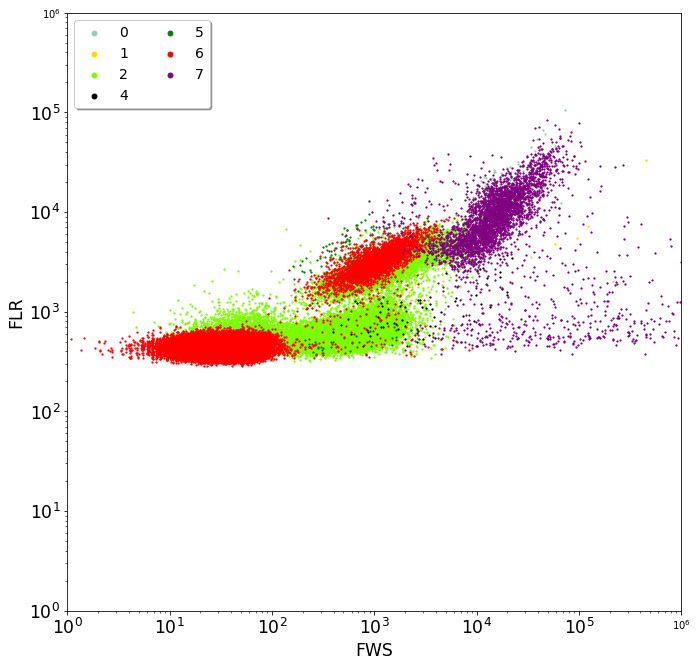

In [ ]:
plot_2Dcyto(XX, yy.astype(str), q1 = 'FWS', q2 = 'FLR', str_labels = True)

In [ ]:
pfg_num = 5
count = pd.DataFrame(index = sets, columns = models)

for file in files: 
  # Pred on these data
  count.loc[file, 'Bench'] = (bench_model.predict(X_files[file]).argmax(1) == pfg_num).sum()
  count.loc[file, 'BenchBig'] = (bench_big.predict(X_files[file]).argmax(1) == pfg_num).sum()
  #count.loc[file, 'VGGSmall'] = (VGG_small.predict(X_files[file]).argmax(1) == pfg_num).sum() 
  #count.loc[file, 'VGGBig'] = (VGG_big.predict(X_files[file]).argmax(1) == pfg_num).sum()
  #count.loc[file, 'Baroud'] = (baroud.predict(X_files[file]).argmax(1) == pfg_num).sum()
  print(count)


                                      Bench BenchBig VGGSmall VGGBig Baroud
Train                                   NaN      NaN      NaN    NaN    NaN
Valid                                   NaN      NaN      NaN    NaN    NaN
Test                                    NaN      NaN      NaN    NaN    NaN
Labelled_Pulse5_2021-03-02 18h11.parq    38       14      NaN    NaN    NaN
                                      Bench BenchBig VGGSmall VGGBig Baroud
Train                                   NaN      NaN      NaN    NaN    NaN
Valid                                   NaN      NaN      NaN    NaN    NaN
Test                                    NaN      NaN      NaN    NaN    NaN
Labelled_Pulse5_2021-03-02 18h11.parq    38       14      NaN    NaN    NaN
Labelled_Pulse5_2021-01-09 08h11.parq   247      158      NaN    NaN    NaN
                                      Bench BenchBig VGGSmall VGGBig Baroud
Train                                   NaN      NaN      NaN    NaN    NaN
Valid       

In [ ]:
baroud.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 120, 5)]          0         
_________________________________________________________________
conv1d_118 (Conv1D)          (None, 116, 32)           832       
_________________________________________________________________
conv1d_119 (Conv1D)          (None, 112, 16)           2576      
_________________________________________________________________
conv1d_120 (Conv1D)          (None, 108, 8)            648       
_________________________________________________________________
global_average_pooling1d_26  (None, 8)                 0         
_________________________________________________________________
dense_83 (Dense)             (None, 32)                288       
_________________________________________________________________
dropout_51 (Dropout)         (None, 32)                0  

In [ ]:
bench_model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 120, 5)]          0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 116, 32)           832       
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 112, 16)           2576      
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 108, 8)            648       
_________________________________________________________________
global_average_pooling1d_21  (None, 8)                 0         
_________________________________________________________________
dense_84 (Dense)             (None, 32)                288       
_________________________________________________________________
dropout_63 (Dropout)         (None, 32)                0  

In [ ]:
del(X_train)
del(X_valid)

In [ ]:
del(y_valid)
del(y_train)

In [ ]:
print(ZZZ)

NameError: ignored

# Import test data

In [ ]:
# Import the test set
test = np.load(current_dir + 'test.npz', allow_pickle = True)
X_test = test['X']
y_test = test['y']
del(test)

## Benchmark models

In [ ]:
from sklearn.metrics import recall_score

### Test set

In [ ]:
models = ['Bench', 'BenchBig', 'VGGSmall', 'VGGBig', 'Baroud']
sets = ['Train', 'Valid', 'Test']
micro_acc = pd.DataFrame(index = sets, columns = models)
macro_acc = pd.DataFrame(index = sets, columns = models)
conf_mtx = {}
per_class_acc = pd.DataFrame()
per_class_rec = pd.DataFrame()

In [ ]:
preds = {}
preds['Bench'] = bench_model.predict(X_test)
preds['BenchBig'] = bench_big.predict(X_test)
preds['VGGSmall'] = VGG_small.predict(X_test)
preds['VGGBig'] = VGG_big.predict(X_test)

In [ ]:
preds['Baroud'] = baroud.predict(X_test)

In [ ]:
conf_mtx['Test'] = {}
y_test_max = y_test.argmax(1)

for spe, preds_ in preds.items():
  preds_spe_max = preds_.argmax(1)
  class_accuracy = precision_score(y_test_max, preds_spe_max,\
                                  average = None, labels = list(range(y_test.shape[1])))
  class_recall = recall_score(y_test_max, preds_spe_max,\
                                  average = None, labels = list(range(y_test.shape[1])))

  micro_acc.loc['Test', spe] = precision_score(y_test_max, preds_spe_max,\
                                  average = 'micro', labels = list(range(y_test.shape[1])))
  macro_acc.loc['Test', spe] = precision_score(y_test_max, preds_spe_max,\
                                  average = 'macro', labels = list(range(y_test.shape[1])))
    
  c_acc = pd.DataFrame(index = tn['name'], data = class_accuracy, columns = [spe + '_Test'])
  c_rec = pd.DataFrame(index = tn['name'], data = class_recall, columns = [spe + '_Test'])

  per_class_acc = per_class_acc.join(c_acc, how = 'right')    
  per_class_rec = per_class_rec.join(c_rec, how = 'right')    

  conf_mtx['Test'][spe] = pd.DataFrame(confusion_matrix(y_test_max, preds_spe_max,\
                      labels = tn['id']), index = tn['name'], columns =  tn['name'])
  

# Print the results

In [ ]:
print(micro_acc.T)
print(macro_acc.T)
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(per_class_acc)

         Train Valid      Test
Bench      NaN   NaN  0.974829
BenchBig   NaN   NaN  0.986196
VGGSmall   NaN   NaN  0.979757
VGGBig     NaN   NaN   0.97335
Baroud     NaN   NaN  0.963106
         Train Valid      Test
Bench      NaN   NaN   0.82291
BenchBig   NaN   NaN  0.907768
VGGSmall   NaN   NaN  0.902721
VGGBig     NaN   NaN  0.913929
Baroud     NaN   NaN  0.823285
            Bench_Test  BenchBig_Test  VGGSmall_Test  VGGBig_Test  Baroud_Test
name                                                                          
MICRO         0.505774       0.824427       0.852174     0.924623     0.872428
ORGNANO       0.597561       0.718954       0.718310     0.815534     0.465969
ORGPICOPRO    0.962508       0.989322       0.989177     0.993557     0.960622
REDNANO       0.684008       0.861853       0.929853     0.835259     0.659803
REDPICOEUK    0.997093       0.994463       0.988390     0.993213     0.994831
REDPICOPRO    0.929418       0.949764       0.949830     0.954622     0.714

# Test on REDPICOPRO rich files

In [ ]:
from scipy.interpolate import interp1d

def quick_preprocessing(df, columns):
  '''
    Preprocess the curves for network predictions (short version of the data_preprocessing function).
    df (pandas DataFrame): The total curves (as in the .parq files)
    ------------------------------------------------------------------
    returns (np.array, list): The formatted curves and the associated class 
    Note: Some Refactoring is needed
  '''

  max_len = 120
  # Reformatting the values
  obs_list = [] # The 5 curves
  #y_list = [] # The class (e.g. 0 = prochlorocchoccus, 1= ...)

  for pid, obs in df.groupby('Particle ID'):
      obs_list.append(obs[columns].values.T)
      #y_list.append(list(set(obs['cluster']))[0])

  #print(obs.columns)
  obs_list = interp_sequences(obs_list, max_len)

  X = np.transpose(obs_list, (0, 2, 1))
  return X#, y_list

def interp_sequences(sequences, max_len):
    ''' Interpolate sequences in order to reduce their length to max_len
        sequences (ndarray): The sequences to interpolate
        maxlen (int): The maximum length of the sequence: All sequences will be interpolated to match this length
        -------------------------------------------------------------------
        returns (ndarray): The interpolated sequences
    '''

    interp_obs = np.zeros((len(sequences), 5, max_len))
    for idx, s in enumerate(sequences):
        original_len = s.shape[1]
        f = interp1d(np.arange(original_len), s, 'quadratic', axis = 1)
        interp_seq = f(np.linspace(0, original_len -1, num = max_len))
        interp_obs[idx] = interp_seq
    
    try:
        return np.stack(interp_obs)
    except ValueError:
        return np.array([])


In [ ]:
%pwd

'/content/gdrive/My Drive/data/SWINGS'

In [ ]:
os.chdir('hardtoclassify/Pulse')
files = os.listdir()

models = ['Bench', 'BenchBig', 'VGGSmall', 'VGGBig']
sets = files

In [ ]:
X_files = {}

                                       Bench BenchBig VGGSmall VGGBig  Baroud
Labelled_Pulse5_2021-03-02 18h11.parq  13509       50       74    350   772.0
Labelled_Pulse5_2021-01-09 08h11.parq  15276      543      527    977  1863.0
Labelled_Pulse5_2021-01-24 16h11.parq   8350       31       47    158   551.0
                                       Bench BenchBig VGGSmall VGGBig  Baroud
Labelled_Pulse5_2021-03-02 18h11.parq  13509       50       74    350   772.0
Labelled_Pulse5_2021-01-09 08h11.parq  15276      543      527    977  2682.0
Labelled_Pulse5_2021-01-24 16h11.parq   8350       31       47    158   551.0
                                       Bench BenchBig VGGSmall VGGBig  Baroud
Labelled_Pulse5_2021-03-02 18h11.parq  13509       50       74    350   772.0
Labelled_Pulse5_2021-01-09 08h11.parq  15276      543      527    977  2682.0
Labelled_Pulse5_2021-01-24 16h11.parq   8350       31       47    158   585.0


In [ ]:
pfg_num = 5

for file in files: 
  # Import data
  pfile = fp.ParquetFile(file)
  df = pfile.to_pandas()
  
  X_file = quick_preprocessing(df, columns = ['FWS', 'SWS', 'FL Red', 'Fl Yellow', 'Curvature'])
  del(df)
  X_files[file] = X_file
  
  # Pred on these data
  #count.loc[file, 'Bench'] = (bench_model.predict(X_file).argmax(1) == pfg_num).sum()
  #count.loc[file, 'BenchBig'] = (bench_big.predict(X_file).argmax(1) == pfg_num).sum()
  #count.loc[file, 'VGGSmall'] = (VGG_small.predict(X_file).argmax(1) == pfg_num).sum() 
  #count.loc[file, 'VGGBig'] = (VGG_big.predict(X_file).argmax(1) == pfg_num).sum()
  #count.loc[file, 'Baroud'] = (baroud.predict(X_file).argmax(1) == pfg_num).sum()
  #print(count)


In [ ]:
pfg_num = 5
count = pd.DataFrame(index = sets, columns = models)

for file in files: 
  # Pred on these data
  count.loc[file, 'Bench'] = (bench_model.predict(X_files[file]).argmax(1) == pfg_num).sum()
  #count.loc[file, 'BenchBig'] = (bench_big.predict(X_files[file]).argmax(1) == pfg_num).sum()
  #count.loc[file, 'VGGSmall'] = (VGG_small.predict(X_files[file]).argmax(1) == pfg_num).sum() 
  #count.loc[file, 'VGGBig'] = (VGG_big.predict(X_files[file]).argmax(1) == pfg_num).sum()
  #count.loc[file, 'Baroud'] = (baroud.predict(X_files[file]).argmax(1) == pfg_num).sum()
  print(count)


                                      Bench BenchBig VGGSmall VGGBig
Labelled_Pulse5_2021-03-02 18h11.parq   174      NaN      NaN    NaN
Labelled_Pulse5_2021-01-09 08h11.parq   NaN      NaN      NaN    NaN
Labelled_Pulse5_2021-01-24 16h11.parq   NaN      NaN      NaN    NaN
                                      Bench BenchBig VGGSmall VGGBig
Labelled_Pulse5_2021-03-02 18h11.parq   174      NaN      NaN    NaN
Labelled_Pulse5_2021-01-09 08h11.parq   735      NaN      NaN    NaN
Labelled_Pulse5_2021-01-24 16h11.parq   NaN      NaN      NaN    NaN
                                      Bench BenchBig VGGSmall VGGBig
Labelled_Pulse5_2021-03-02 18h11.parq   174      NaN      NaN    NaN
Labelled_Pulse5_2021-01-09 08h11.parq   735      NaN      NaN    NaN
Labelled_Pulse5_2021-01-24 16h11.parq    98      NaN      NaN    NaN


In [ ]:
%pwd

'/content/gdrive/My Drive/data/SWINGS/hardtoclassify'

In [ ]:
for file in files: 
  # Import data
  pfile = fp.ParquetFile(file)
  df = pfile.to_pandas()
  
  X_file = quick_preprocessing(df, columns = ['FWS', 'SWS', 'FL Red', 'Fl Yellow', 'Curvature'])
  del(df)
  
  # Pred on these data
  count.loc[file, 'Bench'] = (bench_model.predict(X_file).argmax(1) == pfg_num).sum()
  count.loc[file, 'BenchBig'] = (bench_big.predict(X_file).argmax(1) == pfg_num).sum()
  count.loc[file, 'VGGSmall'] = (VGG_small.predict(X_file).argmax(1) == pfg_num).sum() 
  count.loc[file, 'VGGBig'] = (VGG_big.predict(X_file).argmax(1) == pfg_num).sum()
  print(count)


                                      Bench BenchBig VGGSmall VGGBig
Labelled_Pulse5_2021-03-02 18h11.parq   264      341      136   1096
Labelled_Pulse5_2021-01-09 08h11.parq   NaN      NaN      NaN    NaN
Labelled_Pulse5_2021-01-24 16h11.parq   NaN      NaN      NaN    NaN
                                      Bench BenchBig VGGSmall VGGBig
Labelled_Pulse5_2021-03-02 18h11.parq   264      341      136   1096
Labelled_Pulse5_2021-01-09 08h11.parq    60       59       18    278
Labelled_Pulse5_2021-01-24 16h11.parq   NaN      NaN      NaN    NaN
                                      Bench BenchBig VGGSmall VGGBig
Labelled_Pulse5_2021-03-02 18h11.parq   264      341      136   1096
Labelled_Pulse5_2021-01-09 08h11.parq    60       59       18    278
Labelled_Pulse5_2021-01-24 16h11.parq    62      125       42    546


In [ ]:
(VGG_big.predict(X_file).argmax(1) == 0).sum()

2

In [ ]:
count

,Bench,BenchBig,VGGSmall,VGGBig
Labelled_Pulse5_2021-03-02 18h11.parq,264,341,136,1096
Labelled_Pulse5_2021-01-09 08h11.parq,60,59,18,278
Labelled_Pulse5_2021-01-24 16h11.parq,62,125,42,546
